# Digit Classification

Writer: E.W

Date: 2024/05/27

## Preparation

In [41]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [42]:
# Load dataframe
train_data = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test_data = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

In [43]:
# Separate X,y
X = train_data.iloc[:,1:]
y = train_data.iloc[:,0]
print(
    f"Feature_shape: {X.shape},\nTarget_shape:{y.shape} \nTarget_classes: {y.unique()}"
)


Feature_shape: (42000, 784),
Target_shape:(42000,) 
Target_classes: [1 0 4 7 3 5 8 9 2 6]


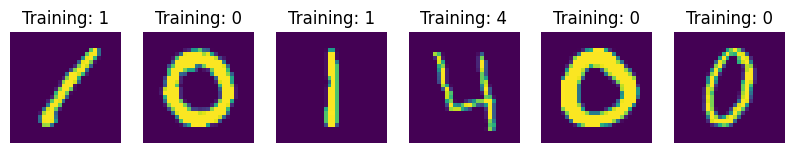

In [44]:
# Check train image
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(10, 3))

for i in range(6):
    image = X.iloc[i].values.reshape(28, 28) # 28*28 = 784
    label = y.iloc[i]
    axes[i].set_axis_off()
    axes[i].imshow(image)
    axes[i].set_title(f"Training: {label}")

In [45]:
# Split Train/Validation
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle=True,random_state=42)
X_train.shape, y_train.shape

((33600, 784), (33600,))

## Linear SVM Model -- baseline model

In [46]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report,accuracy_score

# Use the first 5000 data of the split result to save excecution time
X_train_5000 = X_train[:5000]
y_train_5000 = y_train[:5000]
X_test_5000 = X_test[:5000]
y_test_5000 = y_test[:5000]
svc = SVC(C=100, kernel='linear')
svc.fit(X_train_5000,y_train_5000)
y_pred = svc.predict(X_test_5000)
acc = accuracy_score(y_pred, y_test_5000)
cls_res = classification_report(y_pred,y_test_5000)
print(f"accuracy of linear SVM: {acc}")
print(f"detail report:\n {cls_res}")

accuracy of linear SVM: 0.9036
detail report:
               precision    recall  f1-score   support

           0       0.97      0.95      0.96       483
           1       0.99      0.92      0.96       583
           2       0.90      0.86      0.88       526
           3       0.86      0.89      0.87       570
           4       0.92      0.91      0.92       488
           5       0.85      0.82      0.84       419
           6       0.93      0.95      0.94       472
           7       0.91      0.93      0.92       532
           8       0.82      0.91      0.87       441
           9       0.87      0.89      0.88       486

    accuracy                           0.90      5000
   macro avg       0.90      0.90      0.90      5000
weighted avg       0.91      0.90      0.90      5000



## Linear SVM Model -- tuned model

In [47]:
# Decomposition and normalization
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)
X_train_5000 = pca.fit_transform(X_train_5000)/255.0 # RGB data
X_test_5000 = pca.transform(X_test_5000)/255.0
X_train_5000.shape

(5000, 149)

In [48]:
# Hyper parameter tuner
from sklearn.model_selection import GridSearchCV

params = {"C" : [50,100],
"gamma" : [0.01,0.1],
"degree" : [1,2],
"kernel" : ['linear','poly']}
grid = GridSearchCV(SVC(), params, cv=3)
grid.fit(X_train_5000, y_train_5000)
print(f"the best accuracy is: {grid.best_score_} \nwith the paras: {grid.best_params_}")

the best accuracy is: 0.947799275679078 
with the paras: {'C': 50, 'degree': 2, 'gamma': 0.01, 'kernel': 'poly'}


In [49]:
# Best parameter accuracy
svm_best = grid.best_estimator_
y_pred = svm_best.predict(X_test_5000)
acc = accuracy_score(y_pred, y_test_5000)
cls_res = classification_report(y_pred,y_test_5000)
print(f"accuracy of linear SVM: {acc}")
print(f"detail report:\n {cls_res}")

accuracy of linear SVM: 0.9582
detail report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       467
           1       0.99      0.97      0.98       555
           2       0.97      0.96      0.97       509
           3       0.93      0.95      0.94       571
           4       0.94      0.98      0.96       465
           5       0.98      0.89      0.93       439
           6       0.97      0.97      0.97       486
           7       0.96      0.97      0.96       536
           8       0.92      0.95      0.94       471
           9       0.95      0.94      0.95       501

    accuracy                           0.96      5000
   macro avg       0.96      0.96      0.96      5000
weighted avg       0.96      0.96      0.96      5000



## CNN -- baseline model

In [50]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
torch.manual_seed(42)

# Transform DF to TensorDataset
class TensorDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32).reshape(-1, 1, 28, 28)  # Reshape to n*1x28x28
        self.y = torch.tensor(y.values, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

In [51]:
# Architecture of CNN
class CNN(nn.Module):
    def __init__(self, n_input, n_hidden, n_output):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(n_input, n_hidden, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(n_hidden, n_hidden, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(n_hidden, n_hidden, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(n_hidden, n_hidden, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(), nn.Linear(n_hidden * 7 * 7, n_output)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.classifier(x)
        return x

In [52]:
# Batch feed
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False)
print(f"Length of train dataloader: {len(train_loader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_loader)} batches of {BATCH_SIZE}")

Length of train dataloader: 1050 batches of 32
Length of test dataloader: 263 batches of 32


In [53]:
# Initinization of CNN
cnn = CNN(1, 16, 10)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(cnn.parameters(), lr=0.001)

In [54]:
# Get Train/Test loss and accuracy
def train(model, data_loader,loss_func,optimizer):
    model.train()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    train_loss = 0
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_func(y_pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= len(data_loader)
    print(f"Train loss: {train_loss:.5f}")
    return train_loss


def test(model, data_loader):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    test_loss, test_accuracy = 0, 0
    model.to(device)
    with torch.no_grad():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            y_pred_labels = torch.argmax(y_pred, dim=1)
            test_accuracy += torch.sum(y == y_pred_labels).item()
            loss = loss_func(y_pred, y)
            test_loss += loss.item()
    test_accuracy = 100.0 * test_accuracy / len(data_loader.dataset)
    test_loss /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_accuracy:.5f}")

In [55]:
for epoch in range(5):
    print(f"Epoch {epoch+1}")
    train(cnn, train_loader,loss_func,optimizer)
    test(cnn, test_loader) 

Epoch 1
Train loss: 0.19074
Test loss: 0.06955 | Test accuracy: 97.85714
Epoch 2
Train loss: 0.06353
Test loss: 0.05155 | Test accuracy: 98.53571
Epoch 3
Train loss: 0.04640
Test loss: 0.06489 | Test accuracy: 98.28571
Epoch 4
Train loss: 0.03999
Test loss: 0.05624 | Test accuracy: 98.39286
Epoch 5
Train loss: 0.03729
Test loss: 0.05071 | Test accuracy: 98.50000


## CNN -- tuned model 

In [56]:
# Hyperparameter tuning
n_hiddens = [10, 32, 64, 128] 
learning_rates = [0.0001, 0.005, 0.001, 0.01] 
best_loss = float("inf")
best_params = {}

for n_hidden in n_hiddens:
    for lr in learning_rates:
        model = CNN(n_input=1, n_hidden=n_hidden, n_output=10)
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr)  
        print(f"Training with n_hidden: {n_hidden}, learning rate: {lr}")
        final_train_loss = train(model, train_loader, loss_func, optimizer)
        if final_train_loss < best_loss:
            best_loss = final_train_loss
            best_params = {
                "n_hidden": n_hidden,
                "learning_rate": lr
            }
            print(f"New best loss: {best_loss:.8f}")

print(f"Best parameters found: {best_params} with loss: {best_loss:.8f}")

Training with n_hidden: 10, learning rate: 0.0001
Train loss: 0.46694
New best loss: 0.46693513
Training with n_hidden: 10, learning rate: 0.005
Train loss: 0.24110
New best loss: 0.24110316
Training with n_hidden: 10, learning rate: 0.001
Train loss: 0.19296
New best loss: 0.19296054
Training with n_hidden: 10, learning rate: 0.01
Train loss: 0.28752
Training with n_hidden: 32, learning rate: 0.0001
Train loss: 0.21480
Training with n_hidden: 32, learning rate: 0.005
Train loss: 0.44353
Training with n_hidden: 32, learning rate: 0.001
Train loss: 0.17182
New best loss: 0.17182256
Training with n_hidden: 32, learning rate: 0.01
Train loss: 0.48418
Training with n_hidden: 64, learning rate: 0.0001
Train loss: 0.16970
New best loss: 0.16969858
Training with n_hidden: 64, learning rate: 0.005
Train loss: 1.01729
Training with n_hidden: 64, learning rate: 0.001
Train loss: 0.16945
New best loss: 0.16944880
Training with n_hidden: 64, learning rate: 0.01
Train loss: 2.31167
Training with n_

In [58]:
# Test accuracy with best params
cnn_best = CNN(1, best_params["n_hidden"], 10)
optimizer = torch.optim.AdamW(cnn_best.parameters(), lr=best_params["learning_rate"]) 
for epoch in range(5):
    print(f"Epoch {epoch+1}")
    train(cnn_best, train_loader,loss_func,optimizer)
    test(cnn_best, test_loader) 

Epoch 1
Train loss: 0.14805
Test loss: 0.05812 | Test accuracy: 98.00000
Epoch 2
Train loss: 0.04914
Test loss: 0.04577 | Test accuracy: 98.50000
Epoch 3
Train loss: 0.03280
Test loss: 0.05295 | Test accuracy: 98.36905
Epoch 4
Train loss: 0.02482
Test loss: 0.03009 | Test accuracy: 99.07143
Epoch 5
Train loss: 0.01883
Test loss: 0.04513 | Test accuracy: 98.65476


## Conclusion

Compared SVM with CNN models, the last one is the better one to address image classification problem. 

* SVM only uses 5000 rows data for training but CNN can handle all the data for training and test.
* The performance of CNN(best accuracy: 0.9907) is better than SVM(best accuracy: 0.9582)
* Linear SVM is not the best choice, high demension SVM would be consiedered but the time cost will increase as well.


|                 | SVM  | CNN   |
| --------------- | ---- | ----- |
| Time Complexity | ⭐️⭐️   | ⭐️⭐️⭐️⭐️  |
| Accuracy        | ⭐️⭐️⭐️⭐️ | ⭐️⭐️⭐️⭐️  |
| Expandability   | ⭐️⭐️⭐️  | ⭐️⭐️⭐️⭐️⭐️ |



